In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from numpy.random import default_rng, SeedSequence
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng, SeedSequence
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pandas as pd

sq = SeedSequence()
rng = default_rng(sq)

In [251]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / len(sample))
    return mean, var , mean - ci_size, mean + ci_size

In [438]:
def brownian_1d(n_times: int, n_paths: int, 
                final_time: float=1.0, 
                increments: bool=False, 
                random_state: np.random.Generator=rng) -> np.array:
    """Simulate paths of standard Brownian motion
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        increments: If `True` the increments of the paths are returned.
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths if the argument `increments` is `False`
        `np.array` of shape `(n_times, n_paths)` containing the increments if the argument `increments` is `True`
    """
    dB = np.sqrt(final_time / n_times) * random_state.standard_normal((n_times, n_paths))
    if increments:
        return dB
    else:
        brownian = np.zeros((n_times+1, n_paths))
        brownian[1:] = np.cumsum(dB, axis=0)
        times = np.arange(n_times+1)*(1/n_times)
        t = times[:, np.newaxis]

        return brownian, times

In [439]:
def black_scholes_1d(n_times: int, n_paths: int, 
                     final_time: float=1.0, 
                     random_state: np.random.Generator=rng, *,
                     init_value: float,
                     r: float, sigma: float) -> np.array:
    """Simulate paths of Black-Scholes process
    Args:
        n_times: Number of timesteps
        n_paths: Number of paths 
        final_time: Final time of simulation
        init_value: `S0`
        r: Interest rate
        sigma: Volatility
        random_state: `np.random.Generator` used for simulation
    Returns:
        `np.array` of shape `(n_times+1, n_paths)` containing the paths 
    """
    Bt = brownian_1d(n_times, n_paths)
    times = np.arange(n_times+1)*(1/n_times)
    t = times[:, np.newaxis]
    St = init_value * np.exp((r - 0.5*sigma**2)*t + sigma*Bt)
    S_t = init_value * np.exp((r - 0.5*sigma**2)*t -sigma*Bt)
    return St

In [254]:
def payoff_T(x, T, K,sigma,r,delta,n_times, n_paths):
    Z, times = brownian_1d(n_times, n_paths, T)
    m = (r-delta-sigma**2/2)/sigma

    Z_MC = []
    n = len(Z)
    for i in range(n):
        Z_inter = [max(0, x*np.exp(sigma*Z[i][j])-K) for j in range(len(Z[i]))]
        Z_MC.append(monte_carlo(Z_inter)[0])
    Z_MC = np.array(Z_MC)*np.exp(-(r+m**2/2)*T)
    return Z_MC, times 



[0.    0.001 0.002 ... 0.998 0.999 1.   ]


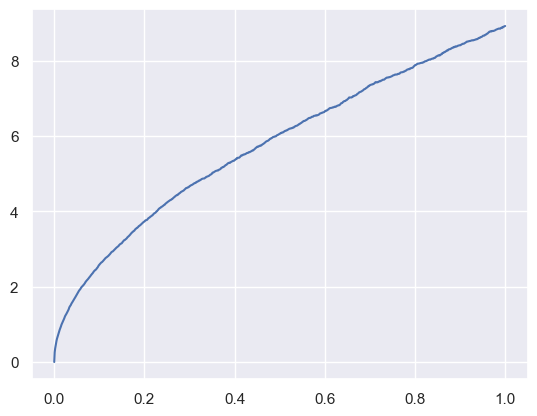

In [255]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.025
delta = 0
n_times = 1000
n_paths = 10000
L = 110
D = 20/360

mc, times =payoff_T(x, T, K,sigma,r,delta,n_times, n_paths)
times = np.linspace(0,T,n_times+1)
print(times)
plt.plot(times, mc)
plt.show()



# Monte Carlo

Calcul du prix d'une option parisienne PDIC via une approche Monte Carlo

In [444]:
from tqdm import tqdm

def pdic_mc(x, T, K, L, D, sigma,r,delta,n_times, n_paths, epsilon):
    Z_plus, times = brownian_1d(n_times, n_paths, T)
    Z_moins = -Z_plus
    times = np.linspace(0,T,n_times+1)
    m = (r-delta-sigma**2/2)/sigma
    b = np.log(L/x)/sigma

    #Pour chaque maturité calcul du payoff sans considérer la conditions sur le temps d'arrêt
    Z_MC = []
    for i in range(n_times):
        Z_inter = [(np.exp(-(r+m**2/2)*T) * max(0, x*np.exp(sigma*Z_plus[i][j])-K) * np.exp(m*Z_plus[i][j]) + np.exp(-(r+m**2/2)*T) * max(0, x*np.exp(sigma*Z_moins[i][j])-K) * np.exp(m*Z_moins[i][j]))/2 for j in range(len(Z_plus[i]))]
        Z_MC.append(Z_inter)

    #Pour chaque simulation, pn calcul le temps d'arret T_b
    #On fixe T_b avec la plus petite valeur possible et on regarde si on peut trouver un g_b correspondant c'est à dire s'il existe un point g_b 
    #avant T_b où la simulation passe par L et reste en dessous pendnat au moins D.
    #Si c'est pas le cas on augmente T_b de 1 et on reregarde l'existence de ce g_b
    T_b = []
    for j in tqdm(range(n_paths)):
        t = 1
        found_T_b = False
        T_b_moins = 1
        while not found_T_b and t < n_times: 
            g_t_b = 0
            k = t
            found_g_b = False
            while k >= 0 and k <= n_times and not found_g_b :
                if abs(Z_plus[k][j] - b) < epsilon :
                    found_g_b = True
                    g_t_b = k
                else : 
                    k-= 1
            if found_g_b == False : 
                t+=1
                #T_b_moins +=1
            elif Z_plus[t][j] < b and times[t] - times[g_t_b] >= D:
                T_b_moins = t
                found_T_b = True
            else : 
                t+=1
                #T_b_moins +=1
        if not found_T_b :  
            T_b_moins = n_times
        for i in range(T_b_moins):  # Correction de la boucle
            Z_MC[i][j] = 0
        T_b.append(T_b_moins)        #print(Z_MC[:][j])
    
    print(T_b)
    mc = []
    mc_conf_inf = []
    mc_conf_sup = []
    for i in range(n_times):
        interval = monte_carlo(Z_MC[i])
        mc.append(interval[0])
        mc_conf_inf.append(interval[2])
        mc_conf_sup.append(interval[3])
    return mc, mc_conf_inf, mc_conf_sup

100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


[1000, 252, 801, 1000, 869, 1000, 1000, 1000, 588, 76, 1000, 1000, 495, 1000, 1000, 286, 1000, 77, 1000, 142, 152, 1000, 1000, 1000, 1000, 1000, 165, 1000, 1000, 722, 320, 169, 189, 1000, 345, 1000, 239, 1000, 518, 331, 1000, 260, 1000, 1000, 987, 518, 1000, 1000, 1000, 786, 180, 1000, 279, 1000, 1000, 1000, 219, 289, 229, 708, 334, 828, 1000, 443, 495, 1000, 926, 1000, 1000, 1000, 847, 1000, 1000, 1000, 355, 257, 1000, 1000, 253, 1000, 630, 982, 730, 1000, 1000, 1000, 456, 897, 1000, 239, 1000, 423, 546, 109, 383, 640, 1000, 449, 1000, 327, 1000, 869, 1000, 1000, 1000, 1000, 196, 1000, 1000, 748, 1000, 797, 1000, 225, 1000, 298, 181, 1000, 1000, 1000, 515, 1000, 154, 546, 1000, 218, 627, 264, 1000, 1000, 1000, 496, 881, 1000, 1000, 231, 521, 846, 744, 1000, 1000, 555, 255, 1000, 1000, 240, 514, 296, 682, 728, 972, 363, 249, 1000, 1000, 1000, 1000, 199, 1000, 1000, 538, 717, 1000, 245, 1000, 283, 329, 1000, 406, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 485, 1000, 1000, 575, 313,

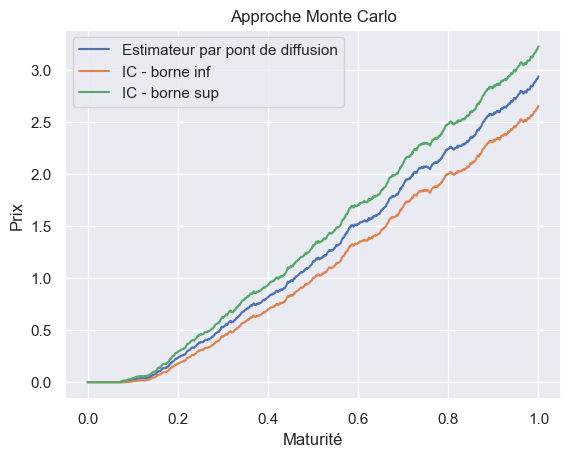

In [445]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.005
delta = 0
n_times = 1000
n_paths = 1000
L = 110
D = 20/360
p = 15
q = 15
alpha = 18.4/(2*T)

#mc = simulate_parisian_option_MC(x, T, K, L, D,sigma,r,delta,n_times, n_paths, epsilon=0.0001)

mc, mc_conf_inf, mc_conf_sup = pdic_mc(x, T, K, L, D,sigma,r,delta,n_times, n_paths, epsilon=0.1)
times = np.linspace(0,T,n_times)
print(mc)

plt.plot(times, mc, label = "Estimateur par pont de diffusion")
plt.plot(times, mc_conf_inf, label = "IC - borne inf")
plt.plot(times, mc_conf_sup, label = "IC - borne sup")
plt.title("Approche Monte Carlo")
plt.legend()
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.show()


100%|██████████| 1000/1000 [01:27<00:00, 11.39it/s]


[1000, 493, 618, 638, 1000, 1000, 808, 493, 583, 322, 1000, 1000, 1000, 413, 1000, 1000, 488, 1000, 972, 1000, 1000, 304, 448, 1000, 278, 555, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 579, 1000, 385, 240, 1000, 719, 1000, 1000, 1000, 1000, 1000, 518, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 302, 1000, 203, 1000, 1000, 1000, 1000, 1000, 606, 1000, 1000, 541, 1000, 1000, 1000, 293, 306, 281, 1000, 1000, 494, 1000, 1000, 1000, 1000, 942, 901, 1000, 1000, 1000, 1000, 398, 100, 200, 1000, 1000, 261, 1000, 285, 1000, 1000, 1000, 670, 1000, 582, 1000, 649, 1000, 1000, 655, 901, 459, 1000, 1000, 1000, 1000, 939, 1000, 1000, 391, 209, 1000, 1000, 1000, 106, 1000, 113, 1000, 1000, 291, 834, 1000, 1000, 1000, 1000, 289, 1000, 180, 496, 1000, 498, 1000, 1000, 985, 555, 936, 1000, 884, 1000, 1000, 1000, 162, 462, 1000, 1000, 467, 293, 517, 1000, 756, 1000, 1000, 1000, 1000, 1000, 348, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 518, 1000, 

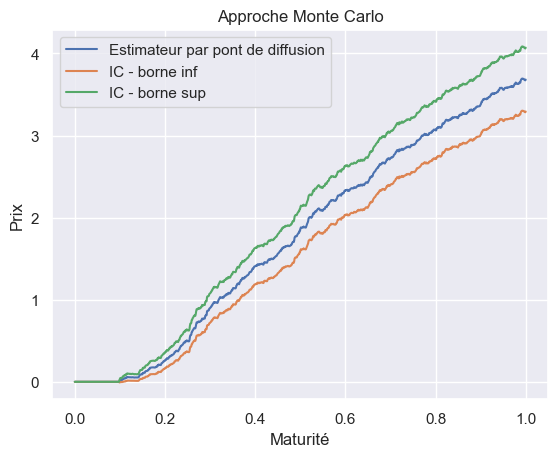

In [446]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.005
delta = 0
n_times = 1000
n_paths = 1000
L = 90
D = 20/360
p = 15
q = 15
alpha = 18.4/(2*T)

#mc = simulate_parisian_option_MC(x, T, K, L, D,sigma,r,delta,n_times, n_paths, epsilon=0.0001)

mc, mc_conf_inf, mc_conf_sup = pdic_mc(x, T, K, L, D,sigma,r,delta,n_times, n_paths, epsilon=0.1)
times = np.linspace(0,T,n_times)
print(mc)


plt.plot(times, mc, label = "Estimateur par pont de diffusion")
plt.plot(times, mc_conf_inf, label = "IC - borne inf")
plt.plot(times, mc_conf_sup, label = "IC - borne sup")
plt.title("Approche Monte Carlo")
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.legend()
plt.show()



# Pont de diffusion

Calcul du prix d'une option parisienne PDIC via une approche par Pont de Diffusion

In [ ]:
sq = SeedSequence()
seed = sq.entropy        # on sauve la graine pour reproduire les résultats
print('seed = ', seed)
rng = default_rng(sq)
rng.uniform()

seed =  95996282963079510372180851872068064828


0.11728892971177729

In [431]:
def G_moins_un(u, x, y, n_times, T):
    return (x + y +np.sqrt((y-x)**2-2*T*(sigma**2)*np.log(1-u)/n_times))/2

def pdic_pont_diffusion(x, T, K, L, D, sigma, r, delta, n_times, n_paths):
    Z, times = brownian_1d(n_times, n_paths, T)
    times = np.linspace(0, T, n_times+1)

    m = (r - delta - sigma ** 2 / 2) / sigma
    b = np.log(L / x) / sigma

    #Pour chaque maturité calcul du payoff sans considérer la conditions sur le temps d'arrêt
    Z_MC = []
    for i in range(n_times):
        Z_inter = [np.exp(-(r + m ** 2 / 2) * T) * max(0, x * np.exp(sigma * Z[i][j]) - K) * np.exp(m * Z[i][j]) for j
                   in range(len(Z[i]))]
        Z_MC.append(Z_inter)

    #Application de la méthode par pont de diffusion (cf rapport) où l'on génère une suite de nombre aléatoire iid de loi uniforme sur [0,1]
    
    T_b = []
    for j in tqdm(range(n_paths)):
        T_b_moins = 0
        found_T_b = False
        while times[T_b_moins] < D:
            T_b_moins += 1
        nb_D = T_b_moins
        T_b_moins += 1
        t_D = 0
        while not found_T_b and T_b_moins < n_times:

            sup_Z = []  
            for k in range(t_D, T_b_moins):
                u = rng.uniform()
                sup_Z.append(G_moins_un(u, Z[k][j], Z[k + 1][j], nb_D, times[nb_D]))
            if max(sup_Z) < b:
                found_T_b = True
            else:
                T_b_moins += 1
                t_D += 1
        if not found_T_b:
            T_b_moins = n_times
        for i in range(T_b_moins):  # Correction de la boucle
            Z_MC[i][j] = 0
        T_b.append(T_b_moins)  # print(Z_MC[:][j])

    print(T_b)
    mc = []
    mc_conf_inf = []
    mc_conf_sup = []
    for i in range(n_times):
        interval = monte_carlo(Z_MC[i])
        mc.append(interval[0])
        mc_conf_inf.append(interval[2])
        mc_conf_sup.append(interval[3])
    return mc, mc_conf_inf, mc_conf_sup

100%|██████████| 1000/1000 [00:56<00:00, 17.57it/s]


[113, 128, 131, 139, 197, 1000, 57, 1000, 137, 63, 281, 148, 76, 107, 57, 152, 353, 57, 141, 57, 1000, 57, 295, 113, 780, 57, 1000, 1000, 57, 1000, 70, 57, 1000, 918, 57, 57, 1000, 1000, 1000, 222, 74, 1000, 57, 57, 302, 78, 57, 71, 166, 57, 57, 123, 526, 426, 440, 135, 1000, 57, 1000, 57, 57, 57, 72, 446, 57, 760, 87, 57, 80, 303, 1000, 65, 294, 57, 57, 195, 171, 77, 57, 93, 134, 57, 57, 57, 1000, 451, 57, 253, 384, 193, 219, 534, 57, 57, 144, 71, 57, 1000, 57, 166, 57, 57, 57, 338, 140, 472, 57, 57, 57, 1000, 57, 57, 375, 57, 1000, 159, 57, 57, 57, 57, 57, 197, 57, 81, 1000, 57, 1000, 199, 57, 104, 131, 57, 63, 57, 77, 93, 57, 57, 156, 84, 1000, 113, 289, 186, 232, 57, 57, 122, 572, 57, 484, 149, 1000, 105, 57, 57, 191, 57, 737, 57, 1000, 57, 81, 285, 57, 250, 1000, 57, 114, 57, 57, 57, 1000, 57, 1000, 57, 1000, 1000, 57, 112, 57, 57, 1000, 57, 57, 64, 85, 1000, 836, 267, 64, 71, 96, 57, 57, 161, 1000, 887, 155, 482, 57, 57, 1000, 57, 78, 267, 110, 90, 744, 57, 57, 191, 57, 57, 514, 

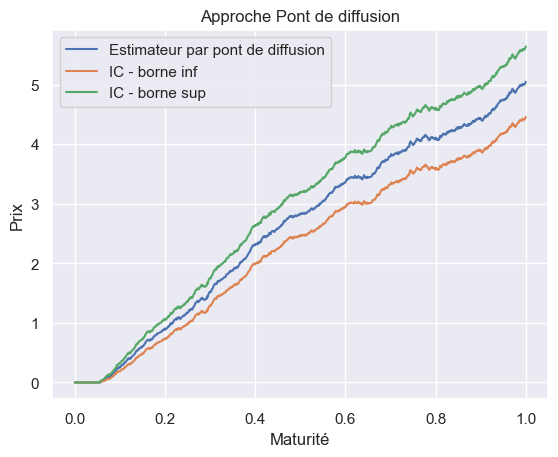

In [422]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.005
delta = 0
n_times = 1000
n_paths = 1000
L = 110
D = 20/360
p = 15
q = 15
alpha = 18.4/(2*T)


#mc = simulate_parisian_option_MC(x, T, K, L, D,sigma,r,delta,n_times, n_paths, epsilon=0.0001)

mc, mc_conf_inf, mc_conf_sup = pdic_pont_diffusion(x, T, K, L, D,sigma,r,delta,n_times, n_paths)
times = np.linspace(0,T,n_times)
print(mc)
#mc = [mc[i][0] for i in range(len(mc))]
plt.plot(times, mc, label = "Estimateur par pont de diffusion")
plt.plot(times, mc_conf_inf, label = "IC - borne inf")
plt.plot(times, mc_conf_sup, label = "IC - borne sup")
plt.title("Approche Pont de diffusion")
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.legend()
plt.show()



100%|██████████| 1000/1000 [02:40<00:00,  6.23it/s]


[1000, 1000, 716, 991, 1000, 1000, 1000, 679, 949, 830, 1000, 943, 1000, 1000, 1000, 1000, 1000, 946, 146, 1000, 585, 1000, 1000, 1000, 464, 1000, 1000, 1000, 1000, 1000, 115, 248, 352, 319, 782, 296, 1000, 1000, 1000, 1000, 1000, 650, 729, 127, 1000, 1000, 1000, 1000, 1000, 195, 335, 560, 614, 832, 1000, 371, 1000, 1000, 660, 1000, 1000, 1000, 360, 1000, 1000, 1000, 233, 600, 1000, 1000, 1000, 680, 1000, 825, 288, 350, 1000, 1000, 873, 1000, 1000, 252, 166, 1000, 403, 1000, 1000, 951, 1000, 1000, 97, 269, 1000, 1000, 1000, 365, 1000, 302, 1000, 473, 1000, 1000, 177, 1000, 434, 1000, 1000, 261, 1000, 375, 260, 1000, 1000, 195, 1000, 1000, 1000, 1000, 443, 1000, 1000, 1000, 566, 1000, 1000, 1000, 1000, 1000, 267, 225, 1000, 1000, 1000, 224, 287, 1000, 333, 889, 606, 212, 1000, 1000, 773, 546, 1000, 1000, 343, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 888, 1000, 158, 733, 1000, 1000, 596, 232, 1000, 1000, 440, 198, 313, 1000, 760, 162, 1000, 447, 170, 

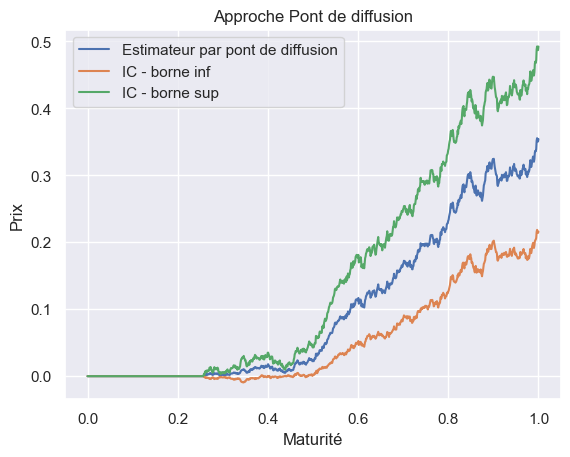

In [434]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.005
delta = 0
n_times = 1000
n_paths = 1000
L = 90
D = 20/360
p = 15
q = 15
alpha = 18.4/(2*T)


#mc = simulate_parisian_option_MC(x, T, K, L, D,sigma,r,delta,n_times, n_paths, epsilon=0.0001)

mc, mc_conf_inf, mc_conf_sup = pdic_pont_diffusion(x, T, K, L, D,sigma,r,delta,n_times, n_paths)
times = np.linspace(0,T,n_times)
print(mc)
#mc = [mc[i][0] for i in range(len(mc))]
plt.plot(times, mc, label = "Estimateur par pont de diffusion")
plt.plot(times, mc_conf_inf, label = "IC - borne inf")
plt.plot(times, mc_conf_sup, label = "IC - borne sup")
plt.title("Approche Pont de diffusion")
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.legend()
plt.show()


# Laplace Transform

## Case of PDIC (Parisian Down and In Call)

In [10]:
from scipy.stats import norm
from scipy.special import comb
import cmath


In [402]:
def psi(z):
    return 1 + z * np.sqrt(2*np.pi)*np.exp((z**2)/2) * norm.cdf(z)


def PDIC_Laplace_star(x,lamda, K, L, D, r, delta):
    m = (r-delta-sigma**2/2)/sigma
    b = np.log(L/x)/sigma
    k = np.log(K/x)/sigma
    d = (b-k)/np.sqrt(D)
    theta = np.sqrt(2*lamda)
    
    if  np.sqrt(lamda.real**2 + lamda.imag**2) <= (m+sigma)**2/2:
        print("lambda error")
    else : 
        if K > L:
            return (psi(-theta*np.sqrt(D)) * np.exp(2*b*theta) * K *np.exp((m-theta) * k) * (1/(m-theta)-1/(m+sigma-theta)) / (theta * psi(theta*np.sqrt(D))))
        
        else : 
            pdic_1 = 2 * K * (psi(m * np.sqrt(D)) - m*np.sqrt(2*np.pi*D)*np.exp(D*(m**2)/2) * norm.cdf(m*np.sqrt(D) + d)) / (m**2 - theta**2)
            pdic_2 = -2 * L * (psi((m+sigma)*np.sqrt(D)) - (m+sigma) * np.sqrt(2 * np.pi * D) * np.exp(D*((m+sigma)**2)/2) * norm.cdf((m+sigma) * np.sqrt(D) + d))/((m+sigma)**2 - theta**2)
            pdic_3 = K * np.exp((m+theta)*k)*(1/(m+theta)-1/(m+sigma+theta)) * (psi(theta*np.sqrt(D)) - theta * np.sqrt(2 * np.pi * D) * np.exp(lamda * D) * norm.cdf(theta * np.sqrt(D)-d))
            pdic_4 = np.exp(lamda * D) * np.sqrt(2*np.pi*D) * K * np.exp(2*b*theta) * np.exp((m-theta)*k) * norm.cdf(-d-theta*np.sqrt(D)) * (1/(m+sigma-theta)-1/(m-theta))/psi(theta*np.sqrt(D))
            
            return (np.exp((m+theta)*b) * (pdic_1 + pdic_2) / psi(theta * np.sqrt(D)) + pdic_3 + pdic_4)
        
def PDIC_Laplace_star_inverse(x, alpha, K, L, D, r, delta, p, q, t):
    def s(n):
        res = 0.0+0.0j
        for l in range(1, n+1):
            res += (-1)**l * PDIC_Laplace_star(x,alpha +(np.pi*l/t)*1j, K, L, D, r, delta).real
        res = np.exp(alpha * t) * PDIC_Laplace_star(x,alpha, K, L, D, r, delta) / (2*t) + np.exp(alpha * t) * res /t
        return res
    pdic = 0
    for l in range(q+1):
        pdic += comb(q, l) * (2**(-q)) * s(p+l)
    return pdic

def PDIC(x, alpha, K, L, D, r, delta, p, q, T):
    m = (r-delta-sigma**2/2)/sigma
    return np.exp(-(r+0.5*m**2)*T) * PDIC_Laplace_star_inverse(x, alpha, K, L, D, r, delta, p, q, T)

/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/1702036369.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  mc = [PDIC(x, 18.4/(2*t), K, L, D, r, delta, p, q, t).real for t in times]
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  res += (-1)**l * PDIC_Laplace_star(x,alpha +(np.pi*l/t)*1j, K, L, D, r, delta).real
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:30: RuntimeWarning: invalid value encountered in multiply
  res += (-1)**l * PDIC_Laplace_star(x,alpha +(np.pi*l/t)*1j, K, L, D, r, delta).real
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  theta = np.sqrt(2*lamda)
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:19: RuntimeWarning: invalid value encountered in cdouble_scalars
  pdic_1 = 

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

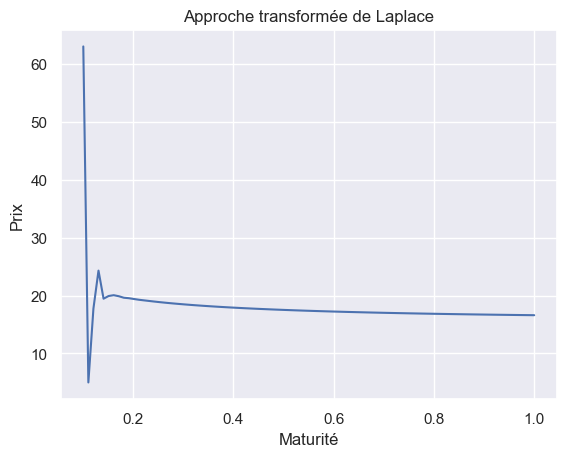

In [424]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.005
delta = 0
n_times = 100
n_paths = 100
L = 110
D = 20/360
p = 15
q = 15

times = np.linspace(0,T,n_times)
mc = [PDIC(x, 18.4/(2*t), K, L, D, r, delta, p, q, t).real for t in times]
print(times)
print(mc)
plt.plot(times[10:], mc[10:])
plt.title("Approche transformée de Laplace")
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.show()



/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3499473801.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  mc = [PDIC(x, 18.4/(2*t), K, L, D, r, delta, p, q, t).real for t in times]
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  res += (-1)**l * PDIC_Laplace_star(x,alpha +(np.pi*l/t)*1j, K, L, D, r, delta).real
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:30: RuntimeWarning: invalid value encountered in multiply
  res += (-1)**l * PDIC_Laplace_star(x,alpha +(np.pi*l/t)*1j, K, L, D, r, delta).real
/var/folders/ly/ylvnx_l518x5nbt0ssvchqww0000gn/T/ipykernel_54627/3539388994.py:10: RuntimeWarning: invalid value encountered in cdouble_scalars
  theta = np.sqrt(2*lamda)
/Applications/anaconda3/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2179: RuntimeWarning: invalid value encountered in greater_equal


[0.         0.001001   0.002002   0.003003   0.004004   0.00500501
 0.00600601 0.00700701 0.00800801 0.00900901 0.01001001 0.01101101
 0.01201201 0.01301301 0.01401401 0.01501502 0.01601602 0.01701702
 0.01801802 0.01901902 0.02002002 0.02102102 0.02202202 0.02302302
 0.02402402 0.02502503 0.02602603 0.02702703 0.02802803 0.02902903
 0.03003003 0.03103103 0.03203203 0.03303303 0.03403403 0.03503504
 0.03603604 0.03703704 0.03803804 0.03903904 0.04004004 0.04104104
 0.04204204 0.04304304 0.04404404 0.04504505 0.04604605 0.04704705
 0.04804805 0.04904905 0.05005005 0.05105105 0.05205205 0.05305305
 0.05405405 0.05505506 0.05605606 0.05705706 0.05805806 0.05905906
 0.06006006 0.06106106 0.06206206 0.06306306 0.06406406 0.06506507
 0.06606607 0.06706707 0.06806807 0.06906907 0.07007007 0.07107107
 0.07207207 0.07307307 0.07407407 0.07507508 0.07607608 0.07707708
 0.07807808 0.07907908 0.08008008 0.08108108 0.08208208 0.08308308
 0.08408408 0.08508509 0.08608609 0.08708709 0.08808809 0.0890

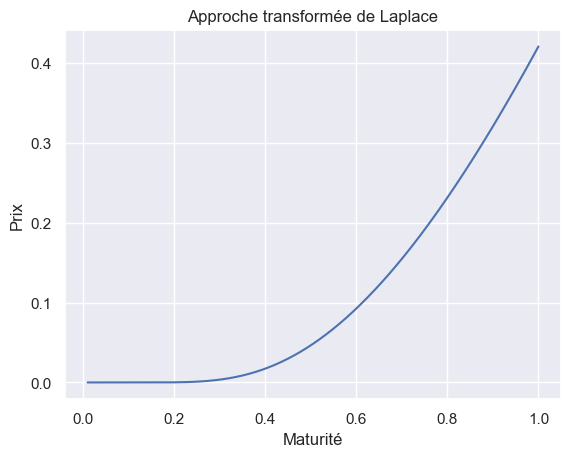

In [429]:
x = 100
T = 1
K = 100
sigma = 0.2
r = 0.005
delta = 0
n_times = 1000
n_paths = 1000
L = 90
D = 20/360
p = 15
q = 15
alpha = 18.4/(2*T)

times = np.linspace(0,T,n_times)
mc = [PDIC(x, 18.4/(2*t), K, L, D, r, delta, p, q, t).real for t in times]
print(times)
print(mc)
plt.plot(times[10:], mc[10:])
plt.title("Approche transformée de Laplace")
plt.xlabel("Maturité")
plt.ylabel("Prix")
plt.show()

